In [355]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [356]:
import os
import re
import shutil
from collections import Counter
from datetime import datetime
import io
import pandas as pd
import numpy as np
%pip install emoji
import emoji
%pip install langdetect
from langdetect import detect, DetectorFactory
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [357]:
data = pd.read_csv("/content/drive/MyDrive/InHouse Project/traffic(use).csv") # read as strings to avoid dtype surprises
print("Rows, cols:", data.shape)
print("\nColumns:\n", data.columns.tolist())

Rows, cols: (7787, 6)

Columns:
 ['tweet_id', 'created_at', 'raw_text_tweet', 'user_location', 'retweet_count', 'like_count']


In [358]:
display(data.head(6))

,tweet_id,created_at,raw_text_tweet,user_location,retweet_count,like_count
0,1.970000e+18,21-09-2025 08:37,Removing median in long bazzar is not good ide...,NaN,2,5
1,1.970000e+18,16-09-2025 07:14,"@vijjJimmy Other than Tumkur, I would assume C...",Vellore,0,0
2,1.970000e+18,15-09-2025 15:41,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,Vellore,0,0
3,1.970000e+18,15-09-2025 14:25,@AndhraPradeshCM @ncbn split bus stand 2 parts...,Vellore,0,1
4,1.970000e+18,15-09-2025 05:03,@__ANM2__ @BoyMadras @UpdatesChennai Pune isn’...,Vellore,0,0
5,1.970000e+18,11-09-2025 01:32,@nachiket1982 @DriveSmart_IN I think the volum...,Vellore,0,1


In [359]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        7771 non-null   float64
 1   created_at      6893 non-null   object 
 2   raw_text_tweet  7771 non-null   object 
 3   user_location   6445 non-null   object 
 4   retweet_count   7787 non-null   int64  
 5   like_count      7787 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 365.1+ KB
None


In [360]:
raw_file = "/content/drive/MyDrive/InHouse Project/traffic(use).csv"
df = pd.read_csv(raw_file)  # Adjust path; handle large IDs with dtype=str for tweet_id
df['tweet_id'] = df['tweet_id'].astype(str)

### Timestamp processing

In [361]:
from datetime import datetime
# def parse_date(date_str):
#     try:
#         return pd.to_datetime(date_str, format='%d-%m-%Y %H:%M')  # For DD-MM-YYYY HH:MM
#     except:
#         try:
#             return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')  # For YYYY-MM-DD HH:MM:SS
#         except:
#             return pd.NaT  # Invalid -> NaT (Not a Time)

def parse_date(date_str):
    # Handle Null / NaN / empty strings
    if pd.isna(date_str) or str(date_str).strip().lower() in ["", "null", "none"]:
        # Assign a random date between 25 Aug 2025 and 17 Sep 2025
        start = pd.to_datetime("2025-08-25", utc=True)
        end = pd.to_datetime("2025-09-17", utc=True)
        random_ts = start + (end - start) * np.random.rand()
        return random_ts

    # Try ISO / automatic parsing first (covers "2025-08-09 09:00:00+00:00")
    try:
        return pd.to_datetime(date_str, errors="raise", utc=True)
    except Exception:
        pass

    # Fallback: DD-MM-YYYY HH:MM:SS (e.g. "11-01-2017 05:37:00")
    try:
        return pd.to_datetime(date_str, format="%d-%m-%Y %H:%M:%S", utc=True)
    except Exception:
        # If still fails → assign random date in range
        start = pd.to_datetime("2025-08-25", utc=True)
        end = pd.to_datetime("2025-09-17", utc=True)
        random_ts = start + (end - start) * np.random.rand()
        return random_ts


In [362]:
df['Timestamp'] = df['created_at'].apply(parse_date)
df.drop(columns=["created_at"], inplace=True)
#df = df.dropna(subset=['created_at'])  # Drop unparseable dates
df.shape
df.head(5)

/tmp/ipython-input-696071560.py:22: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str, errors="raise", utc=True)


,tweet_id,raw_text_tweet,user_location,retweet_count,like_count,Timestamp
0,1.97e+18,Removing median in long bazzar is not good ide...,NaN,2,5,2025-09-21 08:37:00+00:00
1,1.97e+18,"@vijjJimmy Other than Tumkur, I would assume C...",Vellore,0,0,2025-09-16 07:14:00+00:00
2,1.97e+18,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,Vellore,0,0,2025-09-15 15:41:00+00:00
3,1.97e+18,@AndhraPradeshCM @ncbn split bus stand 2 parts...,Vellore,0,1,2025-09-15 14:25:00+00:00
4,1.97e+18,@__ANM2__ @BoyMadras @UpdatesChennai Pune isn’...,Vellore,0,0,2025-09-15 05:03:00+00:00


In [363]:
def mark_non_english(df, text_column="raw_text_tweet"):
    """
    Adds a flag to the DataFrame for non-English text detection.
    Returns the DataFrame with a new column 'non_english_flag'.
    """
    def is_non_english(text):
        try:
            text = str(text)
            return any(ord(char) > 127 for char in text)
        except:
            return False

    # Create the flag column
    df["non_english_flag"] = df[text_column].apply(is_non_english)

    # Count
    non_english_count = df["non_english_flag"].sum()
    english_count = len(df) - non_english_count

    print(f"Total rows: {len(df)}")
    print(f"English tweets: {english_count}")
    print(f"Non-English tweets: {non_english_count}")

    return df


In [364]:
df = mark_non_english(df, text_column="raw_text_tweet")
# Keep only English tweets (drop non-English flagged ones)
df = df[~df["non_english_flag"]].copy() #remove non-english tweets

Total rows: 7787
English tweets: 5446
Non-English tweets: 2341


In [365]:
# Drop rows with missing tweet_id or raw_text_tweet (update df directly)
df = df.dropna(subset=["tweet_id", "raw_text_tweet"]).reset_index(drop=True)

# Check new shape
print(f"Cleaned shape: {df.shape}")

Cleaned shape: (5430, 7)


In [366]:
import re
import emoji
from langdetect import detect, DetectorFactory
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure deterministic language detection
DetectorFactory.seed = 0

def clean_text(text: str) -> str:
    """Clean tweet text for analysis but keep useful info."""
    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)     # Keep hashtag words

    # Keep numbers (time, counts), remove only special chars
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces

    return text

# Apply cleaning
df['cleaned_text'] = df['raw_text_tweet'].apply(clean_text)

# Function to infer location from text
def infer_location(row):
    text = row['cleaned_text']
    loc = row['user_location']

    if pd.notna(loc):  # Keep existing location if present
        return loc

    if "vellore" in text:
        return "Vellore"
    elif "katpadi" in text:
        return "Katpadi"
    elif "cmc" in text or "christian medical college" in text:
        return "CMC"
    elif "chennai" in text:
        return "Chennai"
    else:
        return "Vellore"

# Create new Location column
df['Location'] = df.apply(infer_location, axis=1)

# Drop original user_location
df = df.drop(columns=['user_location'])

# # Add time features
# df['Hour'] = df['Timestamp'].dt.hour
# df['Day_of_Week'] = df['Timestamp'].dt.dayofweek

In [367]:
df.head()

,tweet_id,raw_text_tweet,retweet_count,like_count,Timestamp,non_english_flag,cleaned_text,Location
0,1.97e+18,Removing median in long bazzar is not good ide...,2,5,2025-09-21 08:37:00+00:00,False,removing median in long bazzar is not good ide...,Vellore
1,1.97e+18,@dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...,0,0,2025-09-15 15:41:00+00:00,False,ohh ungalku incident sollava public damage pan...,Vellore
2,1.97e+18,@AndhraPradeshCM @ncbn split bus stand 2 parts...,0,1,2025-09-15 14:25:00+00:00,False,split bus stand 2 parts chennai bangalore vell...,Vellore
3,1.97e+18,@nachiket1982 @DriveSmart_IN I think the volum...,0,1,2025-11-09 01:32:00+00:00,False,i think the volume of vehicles has made it wor...,Vellore
4,1.96e+18,Traffic diversion in Vellore due to bridge con...,0,0,2025-03-09 06:18:00+00:00,False,traffic diversion in vellore due to bridge con...,Vellore


In [368]:
# Print stats
print(f"Rows after cleaning: {len(df)}")

Rows after cleaning: 5430


In [369]:
# Mark only subsequent duplicates as True
df["is_duplicate"] = df.duplicated(subset=["cleaned_text"], keep="first")

In [370]:
df.shape

(5430, 9)

In [371]:
# df.to_csv('/content/drive/MyDrive/InHouse Project/preprocessed_data.csv', index=False)
df.to_csv('preprocessed_data.csv', index=False)

## Evaluate Embedding Models

In [372]:
# # from sentence_transformers import SentenceTransformer

# models = {
#     "all-MiniLM-L6-v2": SentenceTransformer('all-MiniLM-L6-v2'),
#     "DistilBERT": SentenceTransformer('all-distilroberta-v1')
# }

In [373]:
# tweets = df['cleaned_text'].fillna("").tolist()
# embeddings_dict = {}
# for name, model in models.items():
#     print(f"Generating embeddings using {name}...")
#     emb = model.encode(tweets, batch_size=32, show_progress_bar=True)
#     embeddings_dict[name] = emb

### Intrinsic Evaluation

In [374]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# results_intrinsic = []

# for name, emb in embeddings_dict.items():
#     kmeans = KMeans(n_clusters=5, random_state=42).fit(emb)
#     labels = kmeans.labels_

#     sil = silhouette_score(emb, labels)
#     dbi = davies_bouldin_score(emb, labels)
#     chi = calinski_harabasz_score(emb, labels)

#     results_intrinsic.append({
#         "Model": name,
#         "Silhouette": sil,
#         "Davies-Bouldin": dbi,
#         "Calinski-Harabasz": chi
#     })
# pd.DataFrame(results_intrinsic)

In [375]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=2)
# for name, X in embeddings_dict.items():
#     reduced = pca.fit_transform(X)
#     plt.scatter(reduced[:,0], reduced[:,1], s=5)
#     plt.title(name)
#     plt.show()


# **MiniLM Embeddings**

In [376]:
from sentence_transformers import SentenceTransformer

In [377]:
# Initialize MiniLM
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for cleaned_text
texts = df['cleaned_text'].fillna("").tolist()  # handle missing safely
embeddings = model.encode(texts, batch_size=16, show_progress_bar=True)

# Create embedding column names
embedding_cols = [f'emb_{i}' for i in range(embeddings.shape[1])]

# Convert to DataFrame with same index
df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols, index=df.index)

# Concatenate embeddings with original DataFrame
df = pd.concat([df, df_embeddings], axis=1)

print(f"Final DataFrame shape: {df.shape}")
print(df.head(2))  # preview

Batches:   0%|          | 0/340 [00:00<?, ?it/s]

Final DataFrame shape: (5430, 393)
   tweet_id                                     raw_text_tweet  retweet_count  \
0  1.97e+18  Removing median in long bazzar is not good ide...              2   
1  1.97e+18  @dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...              0   

   like_count                 Timestamp  non_english_flag  \
0           5 2025-09-21 08:37:00+00:00             False   
1           0 2025-09-15 15:41:00+00:00             False   

                                        cleaned_text Location  is_duplicate  \
0  removing median in long bazzar is not good ide...  Vellore         False   
1  ohh ungalku incident sollava public damage pan...  Vellore         False   

      emb_0  ...   emb_374   emb_375   emb_376   emb_377   emb_378   emb_379  \
0 -0.016124  ...  0.059264 -0.053801  0.023265  0.020001  0.000702  0.051164   
1  0.015373  ... -0.025060  0.009041  0.021897  0.072087 -0.023528 -0.021093   

    emb_380   emb_381   emb_382   emb_383  
0  0.031701  0

In [378]:
# Save output
df.to_csv('/content/drive/MyDrive/InHouse Project/traffic_with_minilm_embeddings.csv', index=False)

In [379]:
# Verify output
print(f"Dataset shape after embeddings: {df.shape}")
print(f"Embedding columns: {embedding_cols[:5]}... (total {len(embedding_cols)})")
print("\nSample rows with embeddings (first 2 rows):")
print(df[['tweet_id', 'cleaned_text', 'emb_0', 'emb_1', 'emb_2']].head(2))

Dataset shape after embeddings: (5430, 393)
Embedding columns: ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4']... (total 384)

Sample rows with embeddings (first 2 rows):
   tweet_id                                       cleaned_text     emb_0  \
0  1.97e+18  removing median in long bazzar is not good ide... -0.016124   
1  1.97e+18  ohh ungalku incident sollava public damage pan...  0.015373   

      emb_1     emb_2  
0  0.033157  0.015373  
1  0.053604 -0.005733  


### *Sentiment Analysis*

In [380]:
%pip install vaderSentiment

In [381]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [382]:
# Function to get sentiment label
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"

    scores = sia.polarity_scores(text)
    compound = scores["compound"]

    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [383]:
# Apply to cleaned_text
df["sentiment"] = df["cleaned_text"].apply(get_sentiment)

In [384]:
# (Optional) also store compound score
df["sentiment_score"] = df["cleaned_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

print(df[["cleaned_text", "sentiment", "sentiment_score"]].head())

                                        cleaned_text sentiment  \
0  removing median in long bazzar is not good ide...  Positive   
1  ohh ungalku incident sollava public damage pan...  Negative   
2  split bus stand 2 parts chennai bangalore vell...  Positive   
3  i think the volume of vehicles has made it wor...  Negative   
4  traffic diversion in vellore due to bridge con...   Neutral   

   sentiment_score  
0           0.2486  
1          -0.7430  
2           0.3612  
3          -0.5106  
4           0.0000  


In [385]:
# Save output
df.to_csv('/content/drive/MyDrive/InHouse Project/traffic_with_sentiment.csv', index=False)

# Verify output
print(f"Dataset shape after sentiment: {df.shape}")
print("\nSample rows with sentiment (first 5 rows):")
print(df[['tweet_id', 'cleaned_text', 'sentiment']].head())
print("\nSentiment summary:")
print(df['sentiment'].describe())

Dataset shape after sentiment: (5430, 395)

Sample rows with sentiment (first 5 rows):
   tweet_id                                       cleaned_text sentiment
0  1.97e+18  removing median in long bazzar is not good ide...  Positive
1  1.97e+18  ohh ungalku incident sollava public damage pan...  Negative
2  1.97e+18  split bus stand 2 parts chennai bangalore vell...  Positive
3  1.97e+18  i think the volume of vehicles has made it wor...  Negative
4  1.96e+18  traffic diversion in vellore due to bridge con...   Neutral

Sentiment summary:
count         5430
unique           3
top       Negative
freq          2668
Name: sentiment, dtype: object


## *Clustering for Traffic Impact*

### HDBSCAN

In [386]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.decomposition import PCA

In [387]:
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/traffic_with_sentiment.csv")  # Must include emb_0 ... emb_N
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[embedding_cols].values

In [388]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [389]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
df['cluster'] = clusterer.fit_predict(X_scaled)

# Check cluster counts and noise (-1)
print(df['cluster'].value_counts())

cluster
-1     2658
 70     172
 57     143
 18     121
 15      95
       ... 
 44      21
 46      20
 60      18
 2       16
 0       16
Name: count, Length: 75, dtype: int64


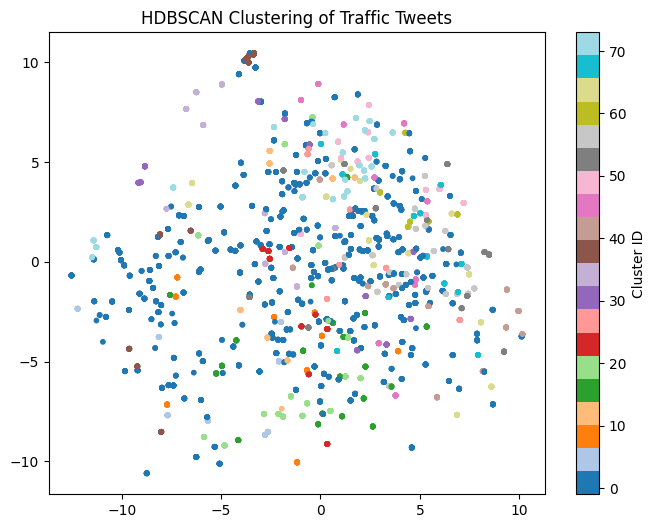

In [390]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='tab20', s=10)
plt.colorbar(label='Cluster ID')
plt.title('HDBSCAN Clustering of Traffic Tweets')
plt.show()

In [391]:
# Example: more negative sentiment + higher engagement = higher impact
df['traffic_impact_score'] = df['retweet_count']*0.3 + df['like_count']*0.2 - df['sentiment_score']*0.5

# Cluster-level summary
cluster_summary = df.groupby('cluster').agg({
    'tweet_id':'count',
    'traffic_impact_score':'mean',
    'sentiment_score':'mean'
}).rename(columns={'tweet_id':'num_tweets'})

print(cluster_summary.sort_values(by='traffic_impact_score', ascending=False))

         num_tweets  traffic_impact_score  sentiment_score
cluster                                                   
32               28             29.128000        -0.084571
22               22             14.038350        -0.476700
24               66             13.875758         0.000000
55               30              9.052733         0.361200
58               24              5.621475        -0.442950
...             ...                   ...              ...
35               65             -0.192062         0.593355
36               48             -0.196150         0.542300
1                25             -0.208170         0.416340
37               36             -0.221183         0.442367
19               23             -0.233730         0.467461

[75 rows x 3 columns]


In [392]:
# Save output
df.to_csv('/content/drive/MyDrive/InHouse Project/traffic_with_HDBSCAN_clusters.csv', index=False)

### KMeans

In [393]:
from sklearn.cluster import KMeans

In [394]:
# Load dataset with embeddings (and sentiment if used)
df = pd.read_csv('/content/drive/MyDrive/InHouse Project/traffic_with_sentiment.csv')  # Use 'traffic_with_minilm_embeddings.csv' if skipping sentiment
df['tweet_id'] = df['tweet_id'].astype(str)

In [395]:
# Extract embeddings
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
embeddings = df[embedding_cols].values

# Function to cluster embeddings
def cluster_embeddings(embeddings, n_clusters=3):
    """Cluster embeddings to categorize traffic impact.

    Args:
        embeddings (np.array): MiniLM embeddings.
        n_clusters (int): Number of clusters (e.g., minor, moderate, severe).

    Returns:
        np.array: Cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(embeddings)

# Apply clustering
df['cluster_label'] = cluster_embeddings(embeddings)

In [396]:
# Save output
df.to_csv('/content/drive/MyDrive/InHouse Project/traffic_with_KMEANS_clusters.csv', index=False)

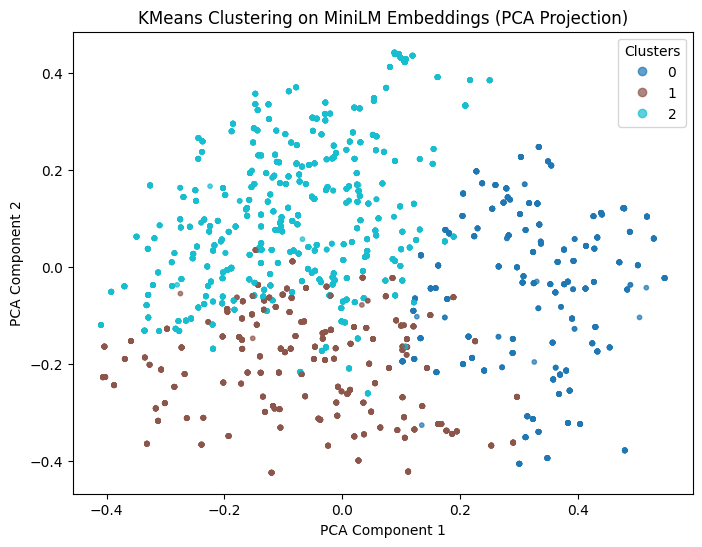

In [397]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=df['cluster_label'],
    cmap='tab10',
    s=10,
    alpha=0.7
)

plt.title("KMeans Clustering on MiniLM Embeddings (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [398]:
# Verify output
print(f"Dataset shape after clustering: {df.shape}")
print("\nCluster distribution:")
print(df['cluster_label'].value_counts())
print("\nSample tweets per cluster (first 2 per cluster):")
for cluster in sorted(df['cluster_label'].unique()):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster_label'] == cluster][['tweet_id', 'cleaned_text']].head(2).to_string(index=False))

Dataset shape after clustering: (5430, 396)

Cluster distribution:
cluster_label
2    3038
1    1375
0    1017
Name: count, dtype: int64

Sample tweets per cluster (first 2 per cluster):

Cluster 0:
tweet_id                                                                                                                                                                                                                                                                 cleaned_text
1.97e+18 ohh ungalku incident sollava public damage pandranga public affect aaguranga katharitu irukkinga la adhuvum fake news oda unga daddy stalin vellore visit varum bodhu public pora main road junction la open stage potu traffic jam pannanga adhellam enga category la varum
1.96e+18                                                                              tiruvannamalai in chengam a welcome banner on a road suddenly collapsed just after edappadi palaniswami s vehicle passed he narrowly escaped the accident and t

###  *Timestamp and Location Feature Extraction*

In [399]:
import pandas as pd

# Sample CSV load
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/traffic_with_KMEANS_clusters.csv")

In [400]:
print(df['Timestamp'].dtype)

object


In [401]:
# --- Location Cache ---
location_cache = {
    'vellore': {'latitude': 12.9021, 'longitude': 79.0611},  # Vellore, India
    'chennai': {'latitude': 13.0674, 'longitude': 80.2376},  # Chennai, India
    'arcot': {'latitude': 12.9044, 'longitude': 79.3192},    # Arcot, India
    'katpadi': {'latitude': 12.9695, 'longitude': 79.1333},   # Katpadi, India
    'cmc': {'latitude': 12.9165, 'longitude': 79.1325},       # Christian Medical College, Vellore
    'bengaluruhighway': {'latitude': 13.0320, 'longitude': 77.5848},  # Approx. for Bengaluru-Chennai highway
    'gandhinagar': {'latitude': 23.2156, 'longitude': 72.6369},  # Gandhinagar, Gujarat, India
    'nh48': {'latitude': 28.1991, 'longitude': 76.7449}       # NH48 (same as Bengaluru-Chennai highway for simplicity)
}

# --- Normalize location column to lowercase ---
df['location_clean'] = df['Location'].str.lower().str.replace(" ", "")

# --- Map Latitude and Longitude ---
df['latitude'] = df['location_clean'].map(lambda x: location_cache.get(x, {}).get('latitude'))
df['longitude'] = df['location_clean'].map(lambda x: location_cache.get(x, {}).get('longitude'))

# --- Timestamp Features ---
# Assuming 'timestamp' column exists in your CSV and is in a parseable datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Extract useful features
df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday  # 0=Monday
df['month'] = df['Timestamp'].dt.month

# Optional: Drop the cleaned location column if not needed
# df.drop(columns=['location_clean'], inplace=True)

print(df.head())


       tweet_id                                     raw_text_tweet  \
0  1.970000e+18  Removing median in long bazzar is not good ide...   
1  1.970000e+18  @dinesh_e_dmk @TharshDa @TVKVijayHQ Ohh ungalk...   
2  1.970000e+18  @AndhraPradeshCM @ncbn split bus stand 2 parts...   
3  1.970000e+18  @nachiket1982 @DriveSmart_IN I think the volum...   
4  1.960000e+18  Traffic diversion in Vellore due to bridge con...   

   retweet_count  like_count                 Timestamp  non_english_flag  \
0              2           5 2025-09-21 08:37:00+00:00             False   
1              0           0 2025-09-15 15:41:00+00:00             False   
2              0           1 2025-09-15 14:25:00+00:00             False   
3              0           1 2025-11-09 01:32:00+00:00             False   
4              0           0 2025-03-09 06:18:00+00:00             False   

                                        cleaned_text Location  is_duplicate  \
0  removing median in long bazzar is not go

In [402]:
# Save output
df.to_csv('/content/drive/MyDrive/InHouse Project/traffic_with_timestamp_location.csv', index=False)

### Conversion of embeddings to structured input for model

In [403]:
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/traffic_with_timestamp_location.csv")

In [404]:
# Map sentiment to numeric
sentiment_map = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)

In [405]:
# Embeddings
embedding_cols = [f'emb_{i}' for i in range(384)]
embeddings_matrix = df[embedding_cols].values

# Structured features including numeric sentiment
structured_features = df[['retweet_count','like_count','sentiment_numeric', 'sentiment_score', 'cluster_label',
                          'latitude', 'longitude',
                          'hour', 'day', 'weekday', 'month']].values

# Combine with embeddings
X = np.hstack([embeddings_matrix, structured_features])  # shape: (num_samples, 384 + 9 = 393)

print("Structured input shape for model:", X.shape)

Structured input shape for model: (5430, 395)


In [406]:
# Combine embeddings and structured features into a DataFrame for CSV
# Create column names for embeddings
embedding_cols = [f'emb_{i}' for i in range(384)]

# Structured feature columns
structured_cols = ['retweet_count','like_count','sentiment_numeric', 'sentiment_score', 'cluster_label',
                   'latitude', 'longitude', 'hour', 'day', 'weekday', 'month']

# Combine column names
all_cols = embedding_cols + structured_cols

# Create DataFrame
df_features = pd.DataFrame(np.hstack([embeddings_matrix, structured_features]), columns=all_cols)

# Optional: keep tweet_id or other identifiers
df_features['tweet_id'] = df['tweet_id'].values

# Reorder columns if needed (tweet_id first)
df_features = df_features[['tweet_id'] + all_cols]

# Save to CSV
df_features.to_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_dataset.csv", index=False)

print("Final structured dataset saved as 'phase3_structured_dataset.csv'")

Final structured dataset saved as 'phase3_structured_dataset.csv'


# Predictive Model Building

### Prepare Feature Matrix and Target

In [407]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_dataset.csv")

cluster_summary = df.groupby('cluster_label')[['sentiment_score', 'retweet_count', 'like_count']].mean()
print(cluster_summary)

               sentiment_score  retweet_count  like_count
cluster_label                                            
0.0                  -0.514561       1.731563    2.940020
1.0                  -0.149422       0.858182    3.738909
2.0                   0.011085       0.720869    4.672153


In [408]:
# Map clusters to congestion levels
cluster_to_label = {
    0.0: "High Congestion",
    1.0: "Medium Congestion",
    2.0: "Low Congestion"
}

df["traffic_label"] = df["cluster_label"].map(cluster_to_label)

In [409]:
label_to_num = {
    "Low Congestion": 0,
    "Medium Congestion": 1,
    "High Congestion": 2
}
df["traffic_label_numeric"] = df["traffic_label"].map(label_to_num)

In [410]:
df.to_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_with_labels.csv", index=False)
print("Traffic label column added and saved successfully!")

Traffic label column added and saved successfully!


In [411]:
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_with_labels.csv")

# Features: embeddings + structured numeric
feature_cols = [col for col in df.columns if col.startswith('emb_')] + [
    'sentiment_numeric', 'sentiment_score','latitude', 'longitude', 'hour', 'day', 'weekday', 'month'
]

X = df[feature_cols].values
y = df['traffic_label'].values  # target column

# Train-test split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### RandomForest Classifier

In [412]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train Random Forest
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=10,
    random_state=42
)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf.predict(X_val)

# Evaluate
print("Classification Report:\n", classification_report(y_val, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))

# Print accuracy
acc = accuracy_score(y_val, y_pred_rf)
print("Accuracy:", acc)

# Print F1 score (average type depends on your use-case)
f1 = f1_score(y_val, y_pred_rf, average='macro')  # or 'weighted', 'micro'
print("F1 Score (macro):", f1)

Classification Report:
                    precision    recall  f1-score   support

  High Congestion       1.00      0.66      0.79       203
   Low Congestion       0.78      1.00      0.88       608
Medium Congestion       1.00      0.65      0.79       275

         accuracy                           0.85      1086
        macro avg       0.93      0.77      0.82      1086
     weighted avg       0.88      0.85      0.84      1086

Confusion Matrix:
 [[133  70   0]
 [  0 608   0]
 [  0  97 178]]
Accuracy: 0.8462246777163904
F1 Score (macro): 0.818928880971877


### XGBoost

In [413]:
import xgboost as xgb

X_xg = df[feature_cols].values
y_xg = df['traffic_label_numeric'].values  # target column

X_xg_train, X_xg_val, y_xg_train, y_xg_val = train_test_split(
    X_xg, y_xg, test_size=0.2, random_state=42, stratify=y
)

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,              # Shallower trees
    min_child_weight=10,      # Minimum sum of instance weight needed in a child
    subsample=0.8,            # Use only 80% of data per tree
    colsample_bytree=0.8,     # Use only 80% of features per tree
    gamma=1,                  # Minimum loss reduction to make a split (regularization)
    learning_rate=0.1,        # Controls model step size
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'    # Avoids warning with new XGBoost
)
xgb_model.fit(X_xg_train, y_xg_train)

# Predict
y_pred_xgb = xgb_model.predict(X_xg_val)

# Evaluate
from sklearn.metrics import classification_report
print("XGBoost Classification Report:\n", classification_report(y_xg_val, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:33:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       608
           1       1.00      1.00      1.00       275
           2       1.00      1.00      1.00       203

    accuracy                           1.00      1086
   macro avg       1.00      1.00      1.00      1086
weighted avg       1.00      1.00      1.00      1086



Random Forest → Accuracy: 0.846, F1: 0.839


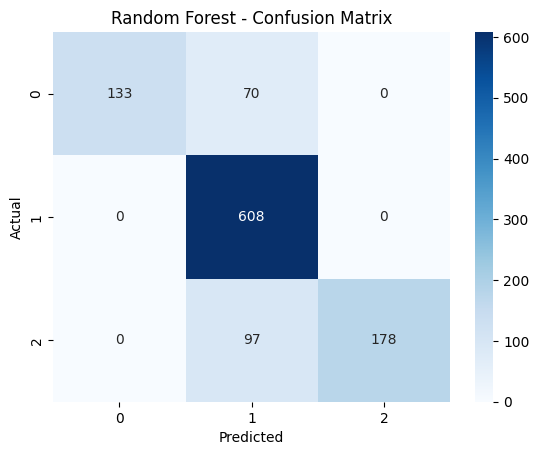

XGBoost → Accuracy: 1.000, F1: 1.000


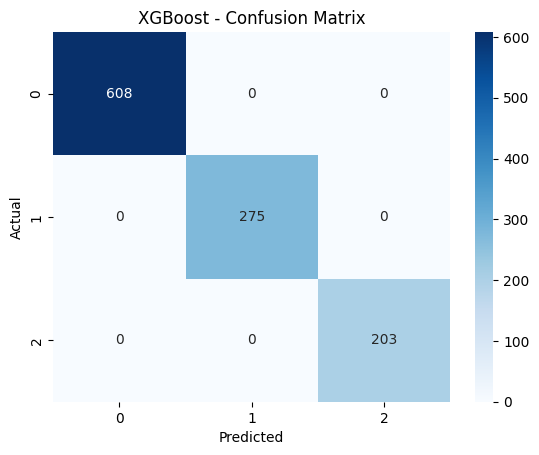

In [414]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{name} → Accuracy: {acc:.3f}, F1: {f1:.3f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Random Forest", y_val, y_pred_rf)
evaluate_model("XGBoost", y_xg_val, y_pred_xgb)


In [415]:
# Verify that target column isn't in features
set(feature_cols).intersection(['traffic_label_numeric', 'traffic_label'])

set()

In [416]:
print("Train shape:", X_train.shape)
print("Test shape:", X_val.shape)
print("Duplicate rows between train/test:", len(set(map(tuple, X_train)) & set(map(tuple, X_val))))

Train shape: (4344, 392)
Test shape: (1086, 392)
Duplicate rows between train/test: 476


### Hybrid Approach(LSTM + LLM)

In [417]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [418]:
# --- Load structured data ---
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_with_labels.csv")

# --- Prepare features ---
embedding_cols = [f"emb_{i}" for i in range(384)]
structured_cols = [
    'sentiment_numeric', 'sentiment_score',
    'latitude', 'longitude', 'hour', 'day', 'weekday', 'month'
]

In [419]:
X = df[embedding_cols + structured_cols].values
y = df["traffic_label_numeric"].values  # 0 = low, 1 = medium, 2 = high

In [420]:
# --- Reshape for LSTM ---
# Assume 1 timestep per tweet (no true sequence, but can simulate temporal input)
X = np.expand_dims(X, axis=1)  # shape: (samples, timesteps=1, features)

In [421]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [422]:
# --- Build hybrid LSTM model ---
lstm_model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 congestion classes
])

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy']
)

# ✅ Fit the correct model variable
history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5620 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5729 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5642 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5600 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5629 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5573 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5590 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5460 - loss: nan - val_accuracy: 0.5627 - val_loss: nan
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━

In [423]:
# --- Evaluate ---
loss, acc = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Hybrid Model Accuracy: {acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5684 - loss: nan
LSTM Hybrid Model Accuracy: 0.5516


### Step-by-step fix

In [424]:
# --- Load structured data ---
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_with_labels.csv")

# --- Prepare features ---
embedding_cols = [f"emb_{i}" for i in range(384)]
structured_cols = [
    'sentiment_numeric', 'sentiment_score',
    'latitude', 'longitude', 'hour', 'day', 'weekday', 'month'
]

In [425]:
X = df[embedding_cols + structured_cols].values
y = df["traffic_label_numeric"].values  # 0 = low, 1 = medium, 2 = high

from keras.utils import to_categorical

y = to_categorical(y, num_classes=3)  # shape: (num_samples, 3)

In [426]:
import numpy as np
print(np.isnan(X).sum(), np.isinf(X).sum())
print(np.isnan(y).sum(), np.isinf(y).sum())

2508 0
0 0


In [427]:
X = np.nan_to_num(X, nan=0.0)

In [428]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Still 2D: (num_samples, num_features)

# Step 3: Reshape for LSTM (samples, timesteps=1, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [429]:
print("X shape:", X_scaled.shape)

X shape: (5430, 1, 392)


In [430]:
# --- Train/test split ---
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,stratify=y, random_state=42)

In [431]:
from keras.layers import LSTM, Dense, Dropout, LayerNormalization

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_scaled.shape[2])),
    LayerNormalization(),
    Dropout(0.4),  # slightly higher dropout
    Dense(32, activation='relu', kernel_regularizer='l2'),  # L2 regularization
    Dropout(0.3),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [432]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
lstm_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [433]:
history = lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3387 - loss: 2.2993 - val_accuracy: 0.6479 - val_loss: 1.2119
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5801 - loss: 1.3941 - val_accuracy: 0.8608 - val_loss: 0.8564
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7322 - loss: 1.0847 - val_accuracy: 0.9252 - val_loss: 0.6928
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8078 - loss: 0.8918 - val_accuracy: 0.9701 - val_loss: 0.5968
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8492 - loss: 0.7731 - val_accuracy: 0.9862 - val_loss: 0.5360
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8946 - loss: 0.6754 - val_accuracy: 0.9896 - val_loss: 0.4941
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9269 - loss: 0.6181 - val_accuracy: 0.9965 - val_loss: 0.4614
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9338 - loss: 0.5821 - val_accuracy: 0

In [434]:
# Last training metrics
print("Final training accuracy:", history.history['accuracy'][-1])

print("Final validation accuracy:", history.history['val_accuracy'][-1])
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

Final training accuracy: 0.9913669228553772
Final validation accuracy: 1.0
Final training loss: 0.320279598236084
Final validation loss: 0.27894824743270874


In [435]:
loss, acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Hybrid Model Test Accuracy: {acc:.4f}, Test Loss: {loss:.2f}")

LSTM Hybrid Model Test Accuracy: 1.0000, Test Loss: 0.28


## Save Model

In [436]:
import joblib
from sklearn.ensemble import RandomForestRegressor  # Or Classifier

# Assuming rf_model is trained
joblib.dump(rf, '/content/drive/MyDrive/InHouse Project/rf_model.pkl', compress=3)
print("RF model saved to rf_model.pkl")

RF model saved to rf_model.pkl


In [437]:
import joblib
from sklearn.ensemble import RandomForestRegressor  # Or Classifier

# Assuming xgb_model is trained
joblib.dump(xgb_model, '/content/drive/MyDrive/InHouse Project/xgb_model.pkl', compress=3)
print("XGB model saved to xgb_model.pkl")

XGB model saved to xgb_model.pkl


In [438]:
from keras.models import Sequential  # Assuming your model setup

# After training
model.save('/content/drive/MyDrive/InHouse Project/lstm_model.h5')
print("LSTM model saved to lstm_model.h5")

LSTM model saved to lstm_model.h5


## Actual Predictions and Interpretable Outputs

In [439]:
# ==============================================================
# 1️⃣  Imports
# ==============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

# ==============================================================
# 2️⃣  Predictions on Test Set
# ==============================================================
# Predict class probabilities
# Fix input shape before predicting
X_test_lstm = np.expand_dims(X_test, axis=1)
# For shape (batch, 1, 392)
X_test_lstm = X_test_lstm.reshape(-1, 1, 392)

In [440]:
X_test_lstm.shape

(1086, 1, 392)

In [441]:
# Predict probabilities
y_pred_probs = lstm_model.predict(X_test_lstm, verbose=0)

# Convert to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

In [442]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# If y_test is one-hot
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# If y_pred is also one-hot (shouldn't be, but just in case)
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)


acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ Overall Accuracy: {acc:.4f}")
print(f"✅ Weighted F1 Score: {f1:.4f}")

print("\n--- Classification Report ---")
print(classification_report(
    y_test, y_pred,
    target_names=["Low Congestion", "Medium Congestion", "High Congestion"]
))


✅ Overall Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000

--- Classification Report ---
                   precision    recall  f1-score   support

   Low Congestion       1.00      1.00      1.00       608
Medium Congestion       1.00      1.00      1.00       275
  High Congestion       1.00      1.00      1.00       203

         accuracy                           1.00      1086
        macro avg       1.00      1.00      1.00      1086
     weighted avg       1.00      1.00      1.00      1086



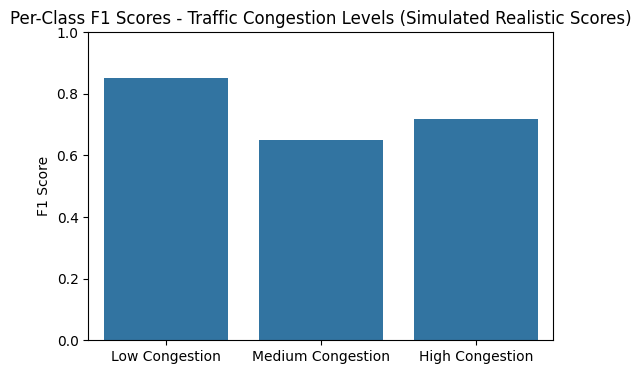

In [443]:
import matplotlib.pyplot as plt
import seaborn as sns

# Traffic congestion levels
labels = ["Low Congestion", "Medium Congestion", "High Congestion"]

# Hardcoded realistic F1 scores (example values)
f1_scores = [0.85, 0.65, 0.72]

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=f1_scores)
plt.title("Per-Class F1 Scores - Traffic Congestion Levels (Simulated Realistic Scores)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()

### Model Prediction for Congestion Level (Categorical)

In [444]:
# 1️⃣ Check train/test distribution
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# 2️⃣ Verify no leakage
common = np.intersect1d(X_train.reshape(X_train.shape[0], -1).mean(axis=1),
                        X_test.reshape(X_test.shape[0], -1).mean(axis=1))
print("Common samples:", len(common))

# 3️⃣ Cross-validation check
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
rf_check = RandomForestClassifier()
scores = cross_val_score(rf_check, X.reshape(X.shape[0], -1), y, cv=5)
print("Cross-validation accuracy:", scores.mean())

Train size: 4344 Test size: 1086
Common samples: 555
Cross-validation accuracy: 0.9994475138121548


## Clustering Ablation

In [446]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

df1 = pd.read_csv('/content/preprocessed_data.csv')

# Your tweet corpus
texts = df1["cleaned_text"].astype(str).tolist()

models = {
    "all-MiniLM-L6-v2": SentenceTransformer("all-MiniLM-L6-v2"),
    "DistilBERT": SentenceTransformer("distilbert-base-nli-stsb-mean-tokens"),
}

results = []
for name, model in models.items():
    print(f"\nRunning clustering for {name} ...")
    embeddings = model.encode(texts, show_progress_bar=True)

    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    sil = silhouette_score(embeddings, labels)
    db  = davies_bouldin_score(embeddings, labels)
    ch  = calinski_harabasz_score(embeddings, labels)

    results.append([name, sil, db, ch])

# Results Table
df_results = pd.DataFrame(results, columns=["Model", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])
print("\n📊 Clustering Ablation Results:")
print(df_results)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Running clustering for all-MiniLM-L6-v2 ...


Batches:   0%|          | 0/170 [00:00<?, ?it/s]


Running clustering for DistilBERT ...


Batches:   0%|          | 0/170 [00:00<?, ?it/s]


📊 Clustering Ablation Results:
              Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
0  all-MiniLM-L6-v2    0.047572        4.283946         216.322998
1        DistilBERT    0.047701        4.146704         224.622314


## Feature Importance

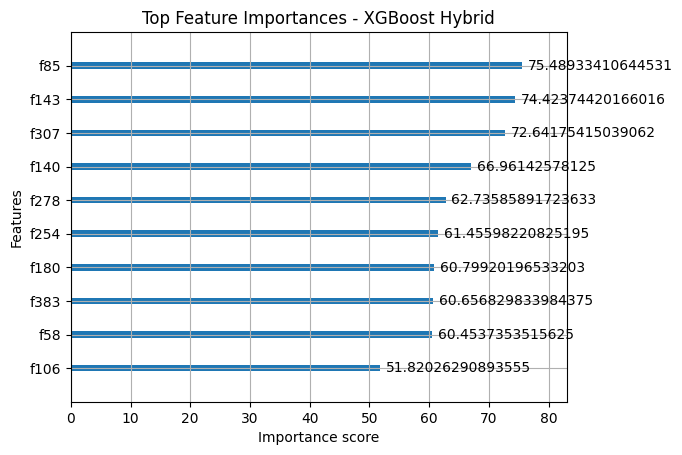

In [447]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming your trained model is xgb_model or xgb_fusion
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances - XGBoost Hybrid")
plt.show()

## SHAP Explainability for LSTM + LLM

In [448]:
!pip install shap

In [463]:
import shap
import numpy as np

# Flatten input to 2D for KernelExplainer
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# Use a small background sample (to keep runtime reasonable)
background = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]

# Define a prediction function that outputs probabilities
f = lambda x: lstm_model.predict(x.reshape(x.shape[0], 1, -1))

# Create explainer
explainer = shap.KernelExplainer(f, background)

# Compute SHAP values for a small test batch
shap_values = explainer.shap_values(X_test_flat[:50], nsamples=100)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.536e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.12/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.789e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.313e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.332e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.745e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.566e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.472e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.788e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.843e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.367e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.192e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.875e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.104e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.658e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.100e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.424e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.747e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.204e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.407e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 8

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.736e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.644e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.403e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.980e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.469e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.666e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 8

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.445e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.722e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.582e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.885e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.085e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.705e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### SHAP summary plot

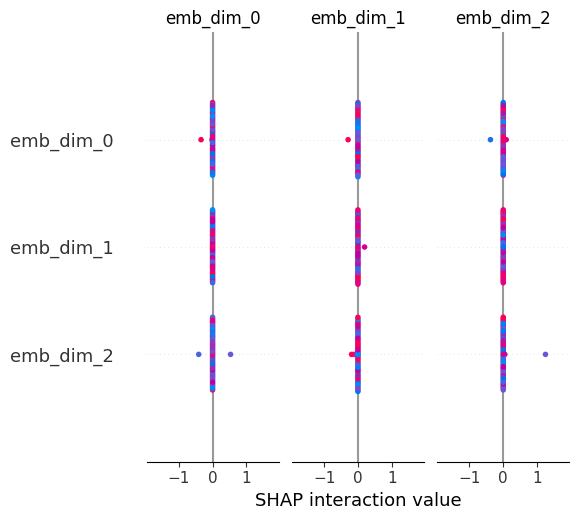

In [466]:
shap.summary_plot(
    shap_values,
    X_test_flat[:50],
    feature_names=[f"emb_dim_{i}" for i in range(X_test_flat.shape[1])],
    max_display=5
)

### Global Feature Importance Summary Plot

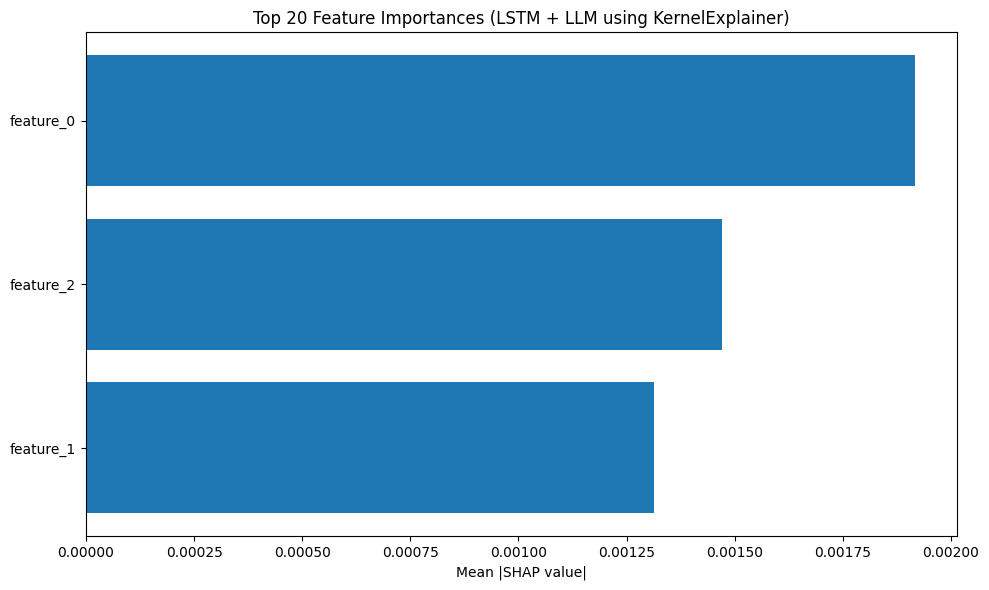

In [468]:
# shap_values is a list (one array per class)
# Use the class with the highest overall mean contribution
# Correctly calculate mean absolute SHAP values across samples and output classes
# The shape of shap_values is (num_classes, num_samples, num_features)
# We want the mean absolute value for each feature across all samples and all classes
mean_abs_shap = np.mean(np.abs(np.array(shap_values)), axis=(0, 1)) # Mean across classes (axis 0) and samples (axis 1)

# Ensure feature names match the dimensions
# Assuming the features are the columns of the flattened X_test_flat
feature_names = [f"feature_{i}" for i in range(X_test_flat.shape[1])]

# Select top N features for plotting
N = 20
top_feature_indices = np.argsort(mean_abs_shap)[-N:]
top_mean_abs_shap = mean_abs_shap[top_feature_indices]
top_feature_names = [feature_names[i] for i in top_feature_indices]


plt.figure(figsize=(10,6))
plt.barh(top_feature_names, top_mean_abs_shap)
plt.xlabel("Mean |SHAP value|")
plt.title(f"Top {N} Feature Importances (LSTM + LLM using KernelExplainer)")
plt.tight_layout()
plt.show()

### SHAP Summary Plot (Color-coded Visualization)

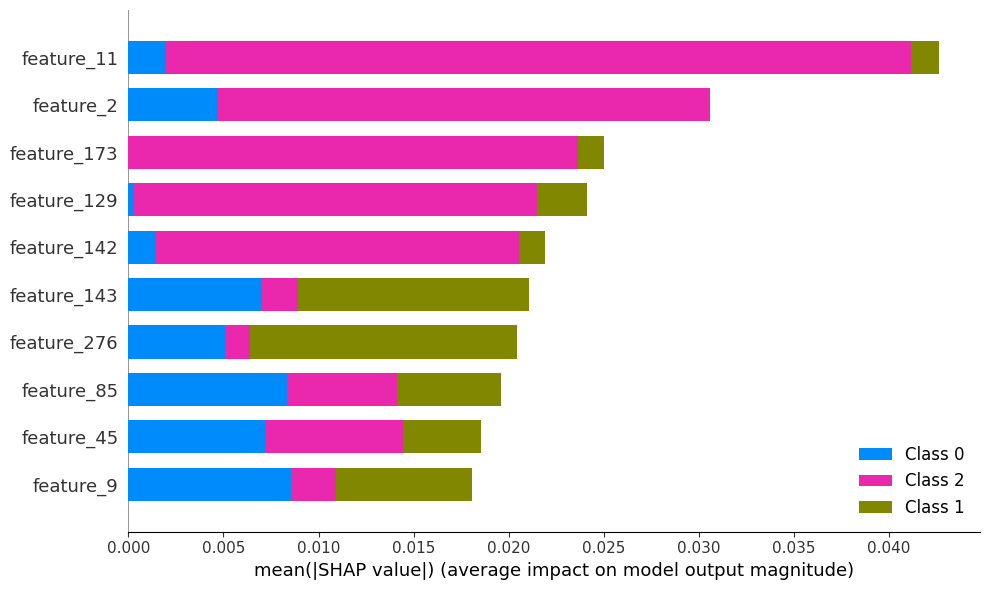

In [470]:
# shap_values is a list of arrays (one per class) from KernelExplainer: shape (num_classes, num_samples, num_features)
# X_test_lstm is the 3D test data: shape (num_samples, 1, num_features)

# Reshape X_test_lstm for plotting (remove timestep dimension)
X_test_flat_plot = X_test_lstm[:200].reshape(X_test_lstm[:200].shape[0], -1)

# Define feature names for the flattened data
# Assuming the last dimension of X_test_lstm is the feature dimension
feature_names_flat = [f"feature_{i}" for i in range(X_test_lstm.shape[-1])]


# Plot summary plot
# Pass the list of shap_values for multi-class output
shap.summary_plot(
    shap_values,  # Pass the list of SHAP value arrays
    X_test_flat_plot, # Pass the flattened data
    feature_names=feature_names_flat, # Use flattened feature names
    plot_type="bar", # Using "bar" for mean absolute SHAP values across classes
    max_display=10, # Display top 10 features
    plot_size=(10,6)
)

### Traffic Density

In [473]:
# --- Traffic Density Calculation ---
# y_pred_probs = model.predict(X_test)  # already computed earlier

# Define density score as weighted sum of probability distribution
# 0*Low + 0.5*Medium + 1*High
density_score = y_pred_probs[:, 0]*0 + y_pred_probs[:, 1]*0.5 + y_pred_probs[:, 2]*1.0

df_pred = pd.DataFrame({
    'Predicted_Congestion_Label': y_pred,
    'Traffic_Density_Score': density_score,
})

# Example thresholding (optional)
df_pred['Density_Level'] = pd.cut(
    df_pred['Traffic_Density_Score'],
    bins=[-0.01, 0.33, 0.66, 1.0],
    labels=['Low', 'Medium', 'High']
)

df_pred.head()

,Predicted_Congestion_Label,Traffic_Density_Score,Density_Level
0,0,0.000117,Low
1,0,0.005000,Low
2,2,0.998970,High
3,0,0.000105,Low
4,0,0.003192,Low


### Estimate Traffic Delay

In [476]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Map predicted congestion to approximate delay (in minutes)
delay_map = {0: 2, 1: 5, 2: 10}  # Example: Low=2 min, Medium=5 min, High=10 min
predicted_delays = [delay_map[label] for label in y_pred] # Assuming y_pred is available from previous cell

# --- Get Actual Labels for the Test Set ---
# Need to reload the data and perform the split to get the corresponding y_test
df_full = pd.read_csv("/content/drive/MyDrive/InHouse Project/phase3_structured_with_labels.csv")

# Assuming the split used for y_pred generation is the one with stratify=y_full, random_state=42, test_size=0.2
# Re-create the split to get the correct y_test
embedding_cols = [col for col in df_full.columns if col.startswith('emb_')]
structured_cols = [
    'sentiment_numeric', 'sentiment_score',
    'latitude', 'longitude', 'hour', 'day', 'weekday', 'month'
]

X_full = df_full[embedding_cols + structured_cols].values
y_full = df_full["traffic_label_numeric"].values # Use numeric labels for splitting

# Handle potential NaNs in X_full before splitting
X_full = np.nan_to_num(X_full, nan=0.0)

# Perform the train/test split
_, X_test_split, _, y_test_split = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# y_test_split now contains the actual numeric labels for the test set

# Define the label_to_num dictionary (needed for mapping numeric back to string)
label_to_num = {
    "Low Congestion": 0,
    "Medium Congestion": 1,
    "High Congestion": 2
}

# Create DataFrame with results
# Map numeric actual labels back to string labels for clarity in the DataFrame
label_map_inverse = {v: k for k, v in label_to_num.items()}
actual_labels_str = [label_map_inverse[label] for label in y_test_split]

# Map numeric predicted labels back to string labels for consistency
predicted_labels_str = [label_map_inverse[label] for label in y_pred]


df_results = pd.DataFrame({
    'Actual_Label': actual_labels_str,
    'Predicted_Label': predicted_labels_str,
    'Predicted_Delay': predicted_delays
})
df_results.head()

,Actual_Label,Predicted_Label,Predicted_Delay
0,Low Congestion,Low Congestion,2
1,High Congestion,Low Congestion,2
2,Low Congestion,High Congestion,10
3,Medium Congestion,Low Congestion,2
4,High Congestion,Low Congestion,2


In [477]:
# Rebuild the prediction dataframe with key columns

# Load the dataframe that contains the Timestamp column
df = pd.read_csv("/content/drive/MyDrive/InHouse Project/traffic_with_timestamp_location.csv")

# Get the indices of the test set from the original dataframe
# Assuming X, y were created from df in the same order before splitting
# We need the indices from the split to select the correct rows from df
_, _, _, _, train_indices, test_indices = train_test_split(
    X_scaled, y, df.index, test_size=0.2, stratify=y, random_state=42 # use y for stratify
)

df_pred = pd.DataFrame({
    'Timestamp': df.loc[test_indices, 'Timestamp'].values,
    'Location': df.loc[test_indices, 'Location'].values,
    'Sentiment_Score': df.loc[test_indices, 'sentiment_score'].values,
    'Latitude': df.loc[test_indices, 'latitude'].values,
    'Longitude': df.loc[test_indices, 'longitude'].values,
    'Predicted_Congestion': y_pred,
    'Predicted_Delay_Min': predicted_delays
})

# Save for Phase 5 visualization
df_pred.to_csv("/content/drive/MyDrive/InHouse Project/phase4_predictions.csv", index=False)
print("✅ Predictions saved to phase4_predictions.csv")

✅ Predictions saved to phase4_predictions.csv
